# Fast IMRPhenomHM Waveform Generation using BBHx for Sage

In [1]:
# Importing necessary packages for fast waveform generation (IMRPhenomHM)
# This should be close enough to the XPHM variant that we use but much faster
import time
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from scipy import signal
from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from bbhx.utils.constants import *

No CuPy or GPU PhenomHM module.


In [119]:
# We can choose to use PhenomD instead (which is the same as XPHM but with only the (2,2) mode)
phenomhm = PhenomHMAmpPhase(use_gpu=False, run_phenomd=True, mf_min=2e-4)

In [128]:
""" Setting waveform params """
f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.0 # phase at f_ref
m1 = 20.0
m2 = 15.0
a1 = 0.0
a2 = 0.0
dist = 1000 * 3.086e+22 # Mpc converted to meters
t_ref = 0.0

In [129]:
""" Waveform generation and check runtime """
start = time.time()
phenomhm(float(m1), float(m2), a1, a2, dist, phi_ref, f_ref, t_ref, 51200)
end = time.time() - start
print('time taken = {} seconds'.format(end))

time taken = 0.04307222366333008 seconds


In [130]:
# get important quantities
freqs = phenomhm.freqs_shaped  # shape (num_bin_all, length)
amps = phenomhm.amp  # shape (num_bin_all, num_modes, length)
phase = phenomhm.phase  # shape (num_bin_all, num_modes, length)
tf = phenomhm.tf  # shape (num_bin_all, num_modes, length)

print('amplitude = {}'.format(amps))
print('phase = {}'.format(phase))

# There are 6 different channels representing different modes
# Running this configruation in PhenomD will give only channel (2, 2)
print(amps.shape, phase.shape)

amplitude = [[[1.98107762e-21 1.98071493e-21 1.98035231e-21 ... 6.66405250e-39
   6.63106703e-39 6.59824034e-39]]]
phase = [[[2.11043841e+04 2.10988885e+04 2.10933943e+04 ... 6.24684060e+00
   6.24912457e+00 6.25140914e+00]]]
(1, 1, 51200) (1, 1, 51200)


In [131]:
# Using a phenomenological form of the waveform is then given by h(t) = h_0 * cost(phi(t))
# where h_0 is the gravitational wave amplitude and phi(t) is the phase
ht = np.fft.irfft(amps * np.exp(-1j*phase))
#ht = amps.flatten() * np.cos(phase.flatten())
print(ht.shape)

(1, 1, 102398)


In [132]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

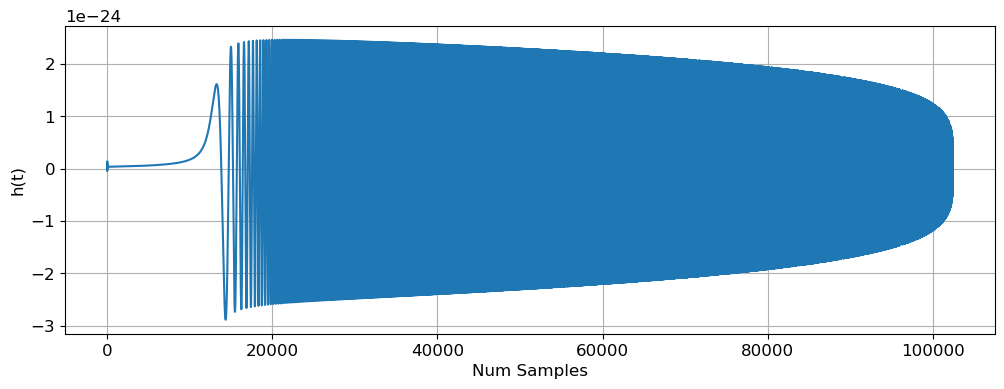

In [133]:
# Plotting the generated waveform
plt.figure(figsize=(12.0, 4.0))
data = ht.flatten()
#data = butter_highpass_filter(data, 125.0, 2048.)
plt.plot(data)
plt.grid(which='both')
plt.xlabel('Num Samples')
plt.ylabel('h(t)')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


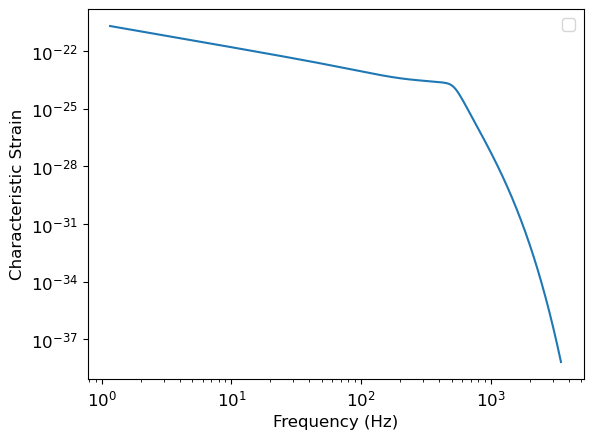

In [134]:
plt.loglog(freqs[0], amps.flatten())
plt.ylabel("Characteristic Strain")
plt.xlabel("Frequency (Hz)")
plt.legend()

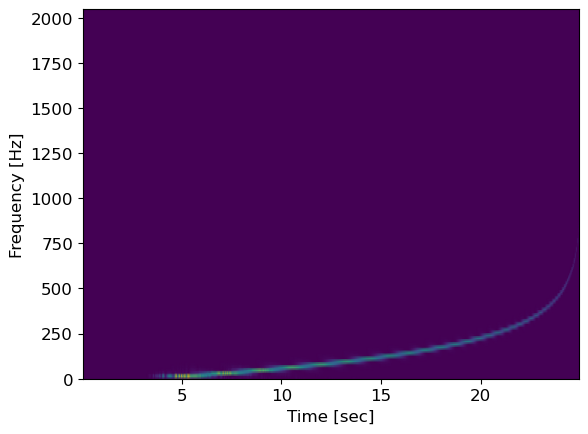

In [135]:
f, t, Sxx = signal.spectrogram(data, fs=4096.)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


## Check whether the waveform generated is consistant with PyCBCs IMRPhenomXPHM

In [11]:
! pip install pycbc

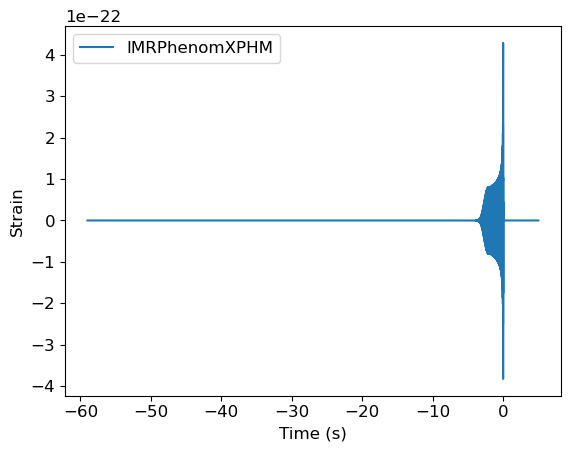

In [136]:
import matplotlib.pyplot as pp
from pycbc.waveform import get_td_waveform

for apx in ['IMRPhenomXPHM']:
    hp, hc = get_td_waveform(approximant=apx,
                                 mass1=20,
                                 mass2=15,
                                 spin1z=0.0,
                                 delta_t=1.0/2048.,
                                 f_lower=20.0,
                                 distance=1000)

    pp.plot(hp.sample_times, hp, label=apx)

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.show()


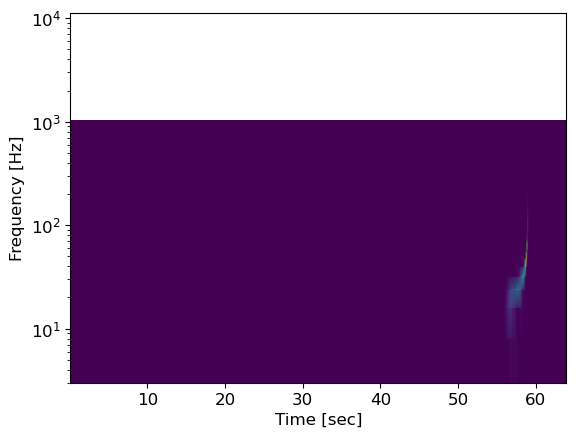

In [137]:
f, t, Sxx = signal.spectrogram(hp, fs=2048.)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.yscale('log')
plt.ylim(3)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()